<a href="https://colab.research.google.com/github/nielsvogell/road-extraction/blob/main/Building_Contour_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helpers

In [ ]:
!pip install diplib

In [ ]:
# Imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import copy
from PIL import Image
from enum import Enum  
from scipy import spatial
from sklearn.mixture import GaussianMixture
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.interpolate import splprep, splev
from  scipy import ndimage
from sklearn.mixture import GaussianMixture
import pickle as pcl
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def plotImages(images, r, c, cmap=None, title=None):
    if title:
        plt.title(title)
    for index, image in enumerate(images):
        plt.subplot(r, c, index + 1)
        plt.axis('off')
        plt.imshow(image, cmap=cmap)
        # plt.tight_layout()
    plt.tight_layout()

In [ ]:
def HSV2RGB(img_hsv):
  return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

def BGR2RGB(img_bgr):
  return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
def morph2(Im,kernel):
 
  (h, w) = Im.shape[:2] # get image dimensions

  for i in range(10):
    Im_d = cv2.dilate(Im, kernel, iterations=1) # dilate
    Im_e = cv2.erode(Im, kernel, iterations=1) # erode
    Im_h = 0.5*(Im_d+Im_e) # combination of dilate and erode

    # if original pixel is darker than dilated and eroded image, keep dilated image else the eroded image
    Im = np.where(Im > Im_h, Im_d, Im_e)
    
  return Im

def morph(Im,kernel):
 
  (h, w) = Im.shape[:2] # get image dimensions

  for i in range(10):
    Im_d = cv2.dilate(Im, kernel, iterations=1) # dilate
    Im_e = cv2.erode(Im, kernel, iterations=1) # erode
    Im_h = 0.5*(Im_d+Im_e) # combination of dilate and erode

    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            if Im[y, x] > Im_h[y,x]:
              Im[y, x] = Im_d[y, x] # if original pixel is darker than dilated and eroded pixel, dilate pixel
            else:
              Im[y, x] = Im_e[y, x] # if original pixel is lighter than dilated and eroded pixel, erode pixel

  return Im

# Jana functions

In [ ]:
def return_color_evaluation(path,show):

  img = cv2.imread(path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  resize=0.3
  blur_size=7

  if blur_size > 0:
      img_rgb = cv2.medianBlur(img_rgb, blur_size)

  # Resize image -> faster clustering
  height, width = img_rgb.shape[:2]
  new_dim = (int(width * resize), int(height * resize))
  img_rgb_resized = cv2.resize(img_rgb, new_dim, interpolation=cv2.INTER_AREA)

  # Cluster
  labels, cluster_colors = gaussian_mixture_cluster(img_rgb, img_rgb_resized=img_rgb_resized, nr_clusters=5)

  for color in cluster_colors.values():
      # Evaluate Color
      evaluation, gray, red, green, blue = evaluate_color(color)

      title_rgb = "rgb color: {}\n".format(color)
      title_colors = "gray: {}%, red: {}%, green: {}%, blue: {}%\n".format(round(gray), round(red), round(green),
                                                                            round(blue))

      background, road, buiding = round(evaluation['background']), round(evaluation['road']), round(evaluation['building'])

      title_labels = "background: {}%, road: {}%, building: {}%".format(background, road, buiding)

      color_swatch_img = [[color] * 6]

      if show:
        plt.figure(figsize=(8, 8))
        plotImages([color_swatch_img], 1, 1, title=title_rgb + title_colors + title_labels)

  (h, w, d) = img_rgb.shape
  label_img = labels.reshape(h, w)
  img_gm = np.zeros_like(img_rgb)
  for lbl, color in cluster_colors.items():
      img_gm[np.where(label_img == lbl)] = color

  if show:
    plt.figure(figsize=(15, 15))
    plotImages([img_gm], 1, 1)

  return img_gm


In [ ]:
def segment(img_rgb, scale=0.5, blur_size=7):
    if blur_size > 0:
        img_rgb = cv2.medianBlur(img_rgb, blur_size)

    # TODO: segment based on specified model
    new_dim = tuple([int(img_rgb.shape[i] * scale) for i in range(2)])
    img_rgb_resized = cv2.resize(img_rgb, new_dim, interpolation=cv2.INTER_AREA)
    labels, cluster_colors = gaussian_mixture_cluster(img_rgb, img_rgb_resized=img_rgb_resized, nr_clusters=6)

    max_probs = {'road': 0, 'building': 0, 'background': 0}
    final_label = {'road': -1, 'building': -1, 'background': -1}
    for lbl, color in cluster_colors.items():
        # Evaluate Color
        evaluation, gray, red, green, blue = evaluate_color(color)

        if evaluation['road'] > max_probs['road']:
            max_probs['road'] = evaluation['road']
            final_label['road'] = lbl
        # TODO: other labels

    # TODO: (optional) change label_img to only include (preliminary) labels for road, building and background
    (h, w, d) = img_rgb.shape
    label_img = labels.reshape(h, w)
    return label_img, final_label


# Arke: Just a comment, this takes a lot of time. It might be a great method, but finding a faster one is desirable.
def gaussian_mixture_cluster(img_rgb, img_rgb_resized=None, nr_clusters=6, b_print=False):
    if img_rgb_resized is not None:
        colors_train = img_rgb_resized.reshape((-1, 3))
    else:
        colors_train = img_rgb.reshape((-1, 3))
    colors_train = np.array(colors_train)

    # how much time does it take
    start = time.time()

    # Cluster with Gaussian Mixture
    gm = GaussianMixture(n_components=nr_clusters, random_state=0).fit(colors_train)

    colors = img_rgb.reshape((-1, 3))
    colors = np.array(colors)
    labels = gm.predict(colors)

    gm_time = time.time() - start
    print("Gaussian Mixture took {}s".format(gm_time))

    unique_labels = np.unique(labels)

    if b_print:
        print("There are {} clusters!".format(len(unique_labels)))

    cluster_colors = {}
    for k in unique_labels:
        b_labeled_k = labels == k
        cluster_colors[k] = np.median(colors[b_labeled_k], axis=0).astype(np.uint8)

        if b_print:
            print("Label: {} with Color: {}\n".format(k, cluster_colors[k]))

    return labels, cluster_colors

# returns building/background/road based on color assignment with "percent_gray_red_green_blue"
def evaluate_color(color_rgb):
    # Arke: Possible code simplification:
    # is_gray could be a one-liner, removing the need for a function definition
    # Probably not faster and not necessarily more readable
    # is_gray = lambda c: (1 - max([abs(c[1] - c[0]), abs(c[2] - c[1]), abs(c[0] - c[2])]) / 255) * 100
    # TODO: Vectorize (low priority)

    gray = is_gray(color_rgb, min(color_rgb) / 2)  # Why the min_color/2?
    red, green, blue = is_red_green_blue(color_rgb)

    # gray -> road or building
    # green and red similar -> background

    if red + green == 0:
        a = 1
    else:
        a = abs(red - green) / (red + green)

    background = (1 - a) * 100
    not_background = (100 - background)

    not_gray = (100 - gray) / 100

    map_type = {'background': background * not_gray, 'road': gray / 2, 'building': not_background * not_gray + gray / 2}

    return map_type, gray, red, green, blue

# returns percentage on how gray
# based on grayish rgb colors have similar values for r, g, b
# Arke: Suggesting to use 255 as diff_range. this gives similar results to standard deviation
#       Suggesting to make this an array function (but for small cluster number the performance gain is not significant)
# Lambda equivalent:
# lambda c : (1 - max([abs(c[1] - c[0]), abs(c[2] - c[1]), abs(c[0] - c[2])]) / 255) * 100
def is_gray(color_rgb, diff_range=100):
  r,g,b = color_rgb.astype(np.int32)
  diffs = abs(r - g), abs(r - b), abs(g - b)
  max_diff = max(diffs)
  gray_percentage = (1 - (max_diff / diff_range)) * 100
  return 0 if gray_percentage < 0 else gray_percentage

# returns array r, g, b of 0-100 percentage
# based on the r, g, b with the highest values and their diff to lower values
def is_red_green_blue(color_rgb, d=0):
    # Arke: Comment - There is no need to split rgb value and also not for the for loops.
    # Only really bad for vectorization of the function. For single-value calculation almost no difference.
    r, g, b = color_rgb

    # subtract half max value
    # -> if lower value less than half of max value -> its too minimal to change color
    max_value = max([r, g, b])
    max_diff = int(max_value / 2)
    r, g, b = [(x - max_diff if x > max_diff else 0) for x in [r, g, b]]

    # subtract min value
    # -> if the lower two values are similar it just grays the first color and doesn't change it
    min_value = min([r, g, b])
    r, g, b = [(x - min_value) for x in [r, g, b]]

    sum_value = r + g + b
    r, g, b = [(x / sum_value) * 100 if x > 0 else x for x in [r, g, b]]

    return [r, g, b]

Gaussian Mixture took 5.566521406173706s


<Figure size 2160x2160 with 0 Axes>

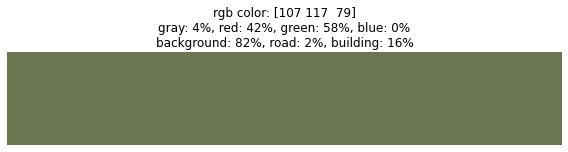

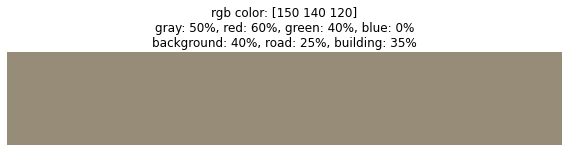

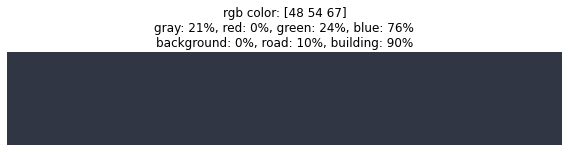

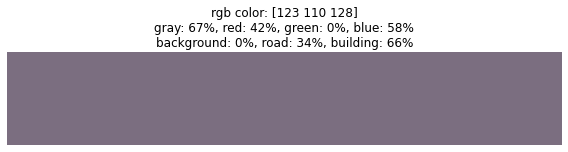

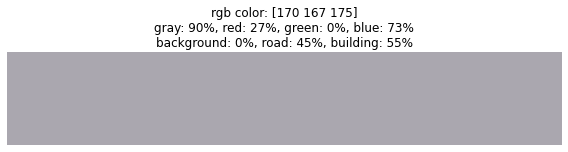

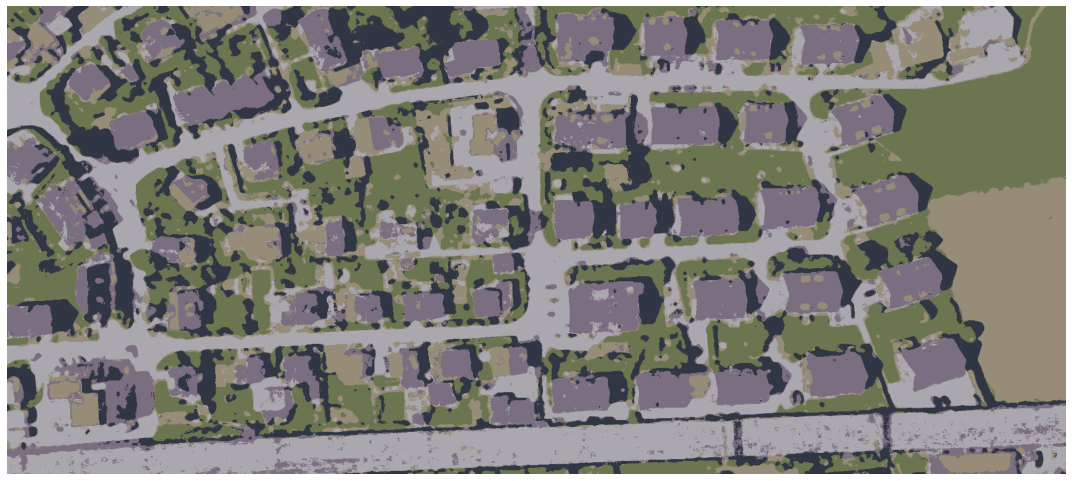

In [ ]:
plt.figure(figsize = (30, 30))
plotImages([return_color_evaluation("3.png",True)], 1, 1)

# **building_detection** function



In [ ]:
""" Detects contours of buildings in the image and display an accuracy metric
@Author : Tanguy Gerniers (W21)
@Args :
  path (str) : The file location of the image.
  output_type(str) :  "mask" : no background
                      "original" : original image as background
                      "tricolor" : 2 clusters (road network in blue, everything else in green) as background
  tresh (int) : Determines whether contours should follow contour edges (0) or bound them within smoother rectangular boxes where possible (120)
  min_building_area(int) : minimum area a building must be to be considered (recommended : 500-1500, depending on height from which image is taken)
  nb_buildings(int) : number of buildings effectively in the image (optional)

@Returns :      output (image) : background of choice with contours of detected buildings in red applied on top as a mask
"""
def building_detection(image_path,output_type,tresh,min_building_area,nb_buildings):

  try:
    color_eval_img, labels = segment(image_path)
  
  except:
    color_eval_img = return_color_evaluation(image_path,False)
    labels = []
  
  image = color_eval_img.copy()

  ### output_type : "mask"

  mask = np.zeros_like(image)

  ### output_type : "tricolor"

  try:
    road_mask = color_eval_img == labels['road']

  except:
    imagea = np.where(image == [170, 167, 175], 255, 0)
    imageb = np.where(image == [48, 54, 67], 0, 0)
    road_mask = (imagea*0.5+imageb*0.5).astype(np.uint8)
    road_mask = road_mask.astype(np.uint8)

  # Blur image to make shapes stand out, remove noise & unnecessary details
  road_filtered = cv2.bilateralFilter(road_mask, 12,20,500)

  # Ensure image is binary for morphological operations
  road_binary = cv2.threshold(road_filtered, 101, 255, cv2.THRESH_BINARY)[1]

  # Remove secondary structures (large, stuctural noise)
  road_morph1 = cv2.morphologyEx(road_binary, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 5)), iterations=4)

  # Reconnect sections of horizontal & vertical roads that may be disconnected by shadows, bridges, etc...
  road_morph2 = cv2.dilate(road_morph1, cv2.getStructuringElement(cv2.MORPH_RECT,(1,5)), iterations=9)
  road_morph3 = cv2.dilate(road_morph2, cv2.getStructuringElement(cv2.MORPH_RECT,(5,1)), iterations=9)

  # Reconnect holes within roads to make uniform shapes
  road_morph4 = cv2.morphologyEx(road_morph3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=3)

  # Enhance features (to counteract dilation operations)
  road_morph5 = cv2.dilate(road_morph4, cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)), iterations=3)

  # Make a mask with just road network in blue
  roads = np.where(road_morph5 == [255, 255, 255], (0,0,255), 0)
  # Make a mask with everything other than road network (=background+buildings) in green
  background = np.where(road_morph5 == [0, 0, 0], (0,255,0), 0)
  # Make a bicolor mask combining a blue road network & green background
  background_and_roads = (background*0.5 + roads*0.5).astype(np.uint8)
  # Apply bicolor mask to original image
  background_and_roads_mask = (color_eval_img.copy()*0.7 + background_and_roads*0.3).astype(np.uint8)

  ### Common code

  if output_type == 'tricolor':
    output = background_and_roads_mask
  elif output_type == 'mask':
    output = mask
  elif output_type == 'original':
    output = color_eval_img.copy()

  try:
    building_mask = color_eval_img == labels['building']

  except:
    imagea = np.where(image == [120, 110, 128], 255, 0)
    imageb = np.where(image == [42, 48, 66], 255, 0)
    imagec = np.where(image == [156, 144, 14], 255, 0)
    building_mask = np.logical_or(imagea, np.logical_or(imageb, imagec))*255
    building_mask = building_mask.astype(np.uint8)

  # Blur image to make shapes stand out, remove noise & unnecessary details
  filtered = cv2.bilateralFilter(building_mask, 12,20,500)

  # Ensure image is binary for morphological operations
  binary = cv2.threshold(filtered, 101, 255, cv2.THRESH_BINARY)[1]

  # Remove secondary structures (large, stuctural noise such as trees, pieces of road that slipped through, etc..)
  morph1 = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=2)

  # Reconnect holes within structures to make uniform shapes
  morph2 = cv2.morphologyEx(morph1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)), iterations=2)

  # Increase structure sizes to merge disconnected portions together
  morph3 = cv2.dilate(morph2, cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)), iterations=3)

  # Detect building edges
  edges = cv2.Canny(morph3, 110, 255)

  # Extract contours & hierarchy from edges
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # list storing contours that are not rectangular
  unique_contours = []
  
  counter = 0
  index = -1
  # for each contour (potential building)
  for contour in contours:
    index +=1
    minx = 10000
    maxx = 0
    miny = 10000
    maxy = 0
    dx = 0
    dy = 0
    # extract positional information of contour
    for point in contour:

      if point[0][0] < minx:
        minx = point[0][0]
      if point[0][0] > maxx:
        maxx = point[0][0]
      if point[0][1] < miny:
        miny = point[0][1]
      if point[0][1] > maxy:
        maxy = point[0][1]
    dx = abs(maxx - minx)
    dy = abs(maxy - miny)

    # if contour is not a road (overly long and thin structure) and not within another contour:
    if dx < 3.5*dy and dy < 3.5*dx and hierarchy[0][index][3] == -1 and ((dx*dy) > min_building_area):

      # records number of contour candidates that are kept to measure accuracy
      counter+=1

      # Get dimensions of general area of contour
      x,y,w,h = cv2.boundingRect(contour)

      # Compute average color of top/bottom left/right corners of the contour
      avg_color_cnt = np.array(cv2.mean(color_eval_img[y : y+h , x : x+w])).astype(np.uint8)
      d0 = int(avg_color_cnt[0]) + int(avg_color_cnt[1]) + int(avg_color_cnt[2])
      avg_color1 = np.array(cv2.mean(color_eval_img[y : y+int(h/2) , x : x+int(w/2)])).astype(np.uint8)
      d1 = int(avg_color1[0]) + int(avg_color1[1]) + int(avg_color1[2])
      avg_color2 = np.array(cv2.mean(color_eval_img[y+int(h/2) : y+h , x : x+int(w/2)])).astype(np.uint8)
      d2 = int(avg_color2[0]) + int(avg_color2[1]) + int(avg_color2[2])
      avg_color3 = np.array(cv2.mean(color_eval_img[y : y+int(h/2) , x+int(w/2) : x+w])).astype(np.uint8)
      d3 = int(avg_color3[0]) + int(avg_color3[1]) + int(avg_color3[2])
      avg_color4 = np.array(cv2.mean(color_eval_img[y+int(h/2) : y+h , x+int(w/2) : x+w])).astype(np.uint8)
      d4 = int(avg_color4[0]) + int(avg_color4[1]) + int(avg_color4[2])

      # If corners of contour are sufficiently similar to one another, it is probably a rectangle/trapezoid -> draw smooth & rectangular bounding box
      if abs(d1-d2)<tresh and abs(d1-d3)<tresh and abs(d1-d4)<tresh and abs(d2-d3)<tresh and abs(d2-d4)<tresh and abs(d3-d4)<tresh:
        # Draw rectangular building contours, in red, onto chosen background
        output = cv2.line(output, (minx,miny), (minx,maxy), (255, 0, 0), 3)
        output = cv2.line(output, (minx,miny), (maxx,miny), (255, 0, 0), 3)
        output = cv2.line(output, (maxx,maxy), (minx,maxy), (255, 0, 0), 3)
        output = cv2.line(output, (maxx,maxy), (maxx,miny), (255, 0, 0), 3)

      # If corners of contour are sufficiently different to one another, it probably has a unique shape -> draw contour as it is
      else:
        unique_contours.append(contour)
      
  try:
    print("Accuracy score :",str((counter/nb_buildings)*100)[:4],"%"," (approximately %i out of %i buildings have been detected)"%(counter,nb_buildings))
  except:
    pass

  # Draw unique building contours, in red,  onto chosen background
  output = cv2.drawContours(output, unique_contours, -1, (255, 0, 0), 3)

  return output

Gaussian Mixture took 3.610240936279297s
Accuracy score : 93.3 %  (approximately 56 out of 60 buildings have been detected)


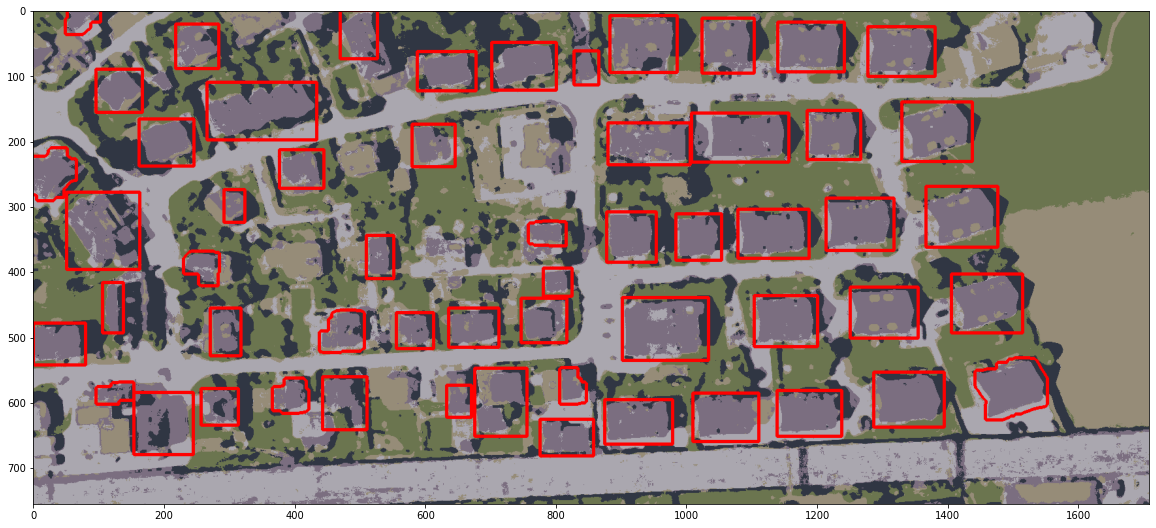

In [ ]:
plt.figure(figsize = (20, 20))
plt.imshow(building_detection("3.png","original",120,1500,60),cmap="gray")

The building_detection function allows us to locate and highlight buildings on images. 

First, we apply a bilateral filter, various open/close/dilate morphological operations & canny edge detection to obtain candidate building contours.

Next, we remove structures that are too long (potential streets), too small (noise) or within other structures to filter out real building contours.

Then, we distinguish between rectangular/trapezoid that can be bound by clean, 4 edge boxes, and uniquely shaped buildings to facilitate representation.

Lastly, we display an accuracy score demonstrating how many buildings our code was able to detect in the image.

Various parameters allow us to fine-tune the model to specific images and maximize our accuracy score.

This model is optimized for high quality, high luminosity images of rural neighborhoods with a modern road system (tarmac) that is aligned with the borders of the image, well aligned, bright colored and sufficiently distanced houses, and as little shadows as possible (images ideally taken at noon).